# House Price Challenge

The housing market is one of the most crucial parts of every country's economy. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a central topic in economic and financial circles.

The [houseprices dataset from Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) includes several features of the houses, along with their sale prices at the time that they are sold. So far in this module, we have built and implemented some models using this dataset.

In this challenge, we are required to improve our model with respect to its prediction performance. We will perform the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.
3. Now, split the data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including lasso, ridge, or elastic net, and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if the models include one.
5. Evaluate your best model on the test set.
6. So far, we have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


First, we load create a database connection to house price data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sqlalchemy import create_engine, text

import warnings
warnings.filterwarnings('ignore')

# Read the full contents of the dataframes
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


### 1. Load the houseprices data from Thinkful's database.

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_price_df = pd.read_sql_query(text('SELECT * FROM houseprices'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

In [3]:
print("Full train dataset shape is {}".format(house_price_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. There are 79 feature columns describing many aspects of residential homes in Ames, Iowa. Using this data, our task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

### 2. Do data cleaning, exploratory data analysis, and feature engineering. We can use our previous work in this module. But, make sure that our work is satisfactory.

Let's first classify which columns are numerical and which are non-numerical.

In [4]:
# Numerical
numeric_columns = house_price_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [5]:
# Non-Numerical
non_numeric_columns = house_price_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


We need to address the columns with missing values. These are

In [6]:
missing_mask = house_price_df.isna()
total_missing = missing_mask.sum().sort_values(ascending=False)
percent_missing = (missing_mask.sum() / missing_mask.count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percent Missing'])
missing_data.head(19)

,Total Missing,Percent Missing
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garageyrblt,81,0.055479
garagecond,81,0.055479
garagetype,81,0.055479
garagefinish,81,0.055479


We will drop the first five: `poolqc`,`miscfeature`, `alley`, `fence`, and `electrical`. We will also drop the `id` column.

In [7]:
house_price_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Next, we define a function to clean the remaining numerical and non-numerical columns.

In [8]:
def clean_null_columns(df):
  for col in df:
    feature = df[col]
    if col in numeric_columns and feature.isnull().values.any():
      feature.fillna(feature.median(), inplace=True)
    elif col in non_numeric_columns and feature.isnull().values.any():
      for i in range(0, len(feature)):
        most_freq_val = feature.value_counts().idxmax()
        if pd.isnull(feature[i]):
            feature[i] = most_freq_val

clean_null_columns(house_price_df)

We also remove outliers from our target variable.

In [9]:
# Remove large outliers from the dataset before training.
outlier = house_price_df['saleprice'].quantile(.99)
house_price_df = house_price_df[house_price_df['saleprice'] < outlier]

Next, let's define a new function to look at a correlation map of the features of interest and the target variable.

In [10]:
def heatmap_features_and_target(df, n_cols):
  corr = df.corr()
  correlated_columns = corr['saleprice'].sort_values(ascending=False).head(n_cols).index
  corr_of_correlated_columns = df[correlated_columns].corr()

  fig=plt.figure(figsize=(15,10))
  sns.heatmap(corr_of_correlated_columns,cmap='Blues',annot=True)

We can now examine a correlation matrix between the top 20 features and  `saleprice`.

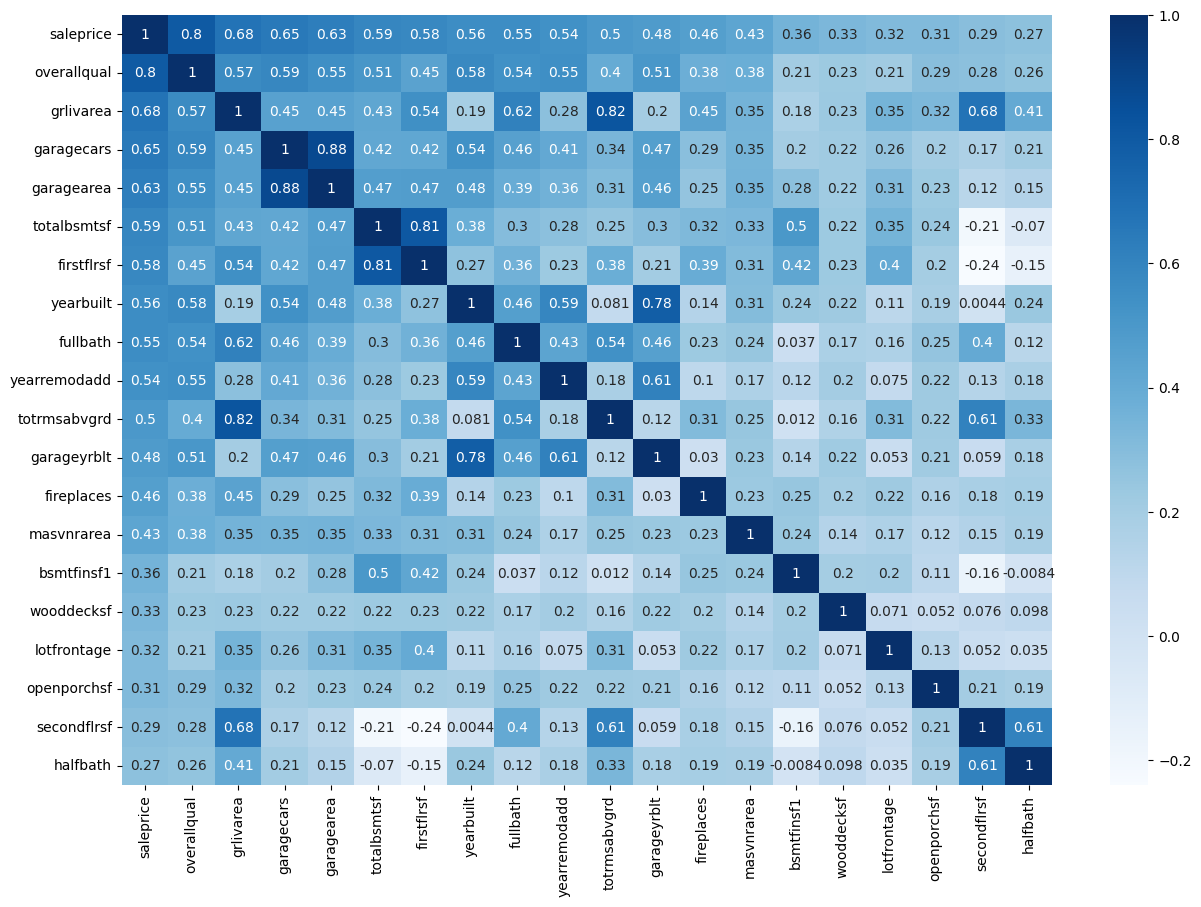

In [11]:
heatmap_features_and_target(house_price_df, 20)

We previously found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [12]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

 We also found that we can improve the model by increasing the goodness of fit. To do this, we execute the steps below:

- We first log transform the dependent variable. Recall from the histogram above that the `saleprice` variable is not normally distributed, so log transforming may help in this regard. To this end, we apply `log(1+x)` transformation of NumPy.
- Second, we create another variable by summing up the basement, first and the second floor areas.
- Third, we add the interaction of the total area and the overall quality of the house.
- Fourth, we drop the explanatory variable that aren't statistically significant.

In [13]:
house_price_reduced_df = house_price_df.copy()
unwanted_features = ['mszoning_FV','mszoning_RH',
                     'mszoning_RM','street_Pave',
                    'utilities_NoSeWa','salecondition_AdjLand',
                    'salecondition_Alloca','salecondition_Family']
dummy_column_names_reduced = [e for e in dummy_column_names if e not in unwanted_features]

We now finish creating the new dataframe with the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`. We also include the steps performed to increase the goodness of fit.

In [14]:
house_price_reduced_df['totalsf'] = house_price_reduced_df['totalbsmtsf'] + house_price_reduced_df['firstflrsf'] + house_price_reduced_df['secondflrsf']
house_price_reduced_df['int_over_sf'] = house_price_reduced_df['totalsf'] * house_price_reduced_df['overallqual']
house_price_reduced_df = house_price_reduced_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'totalsf', 'int_over_sf'] + dummy_column_names_reduced]

We visualize these changes through a new heatmap.

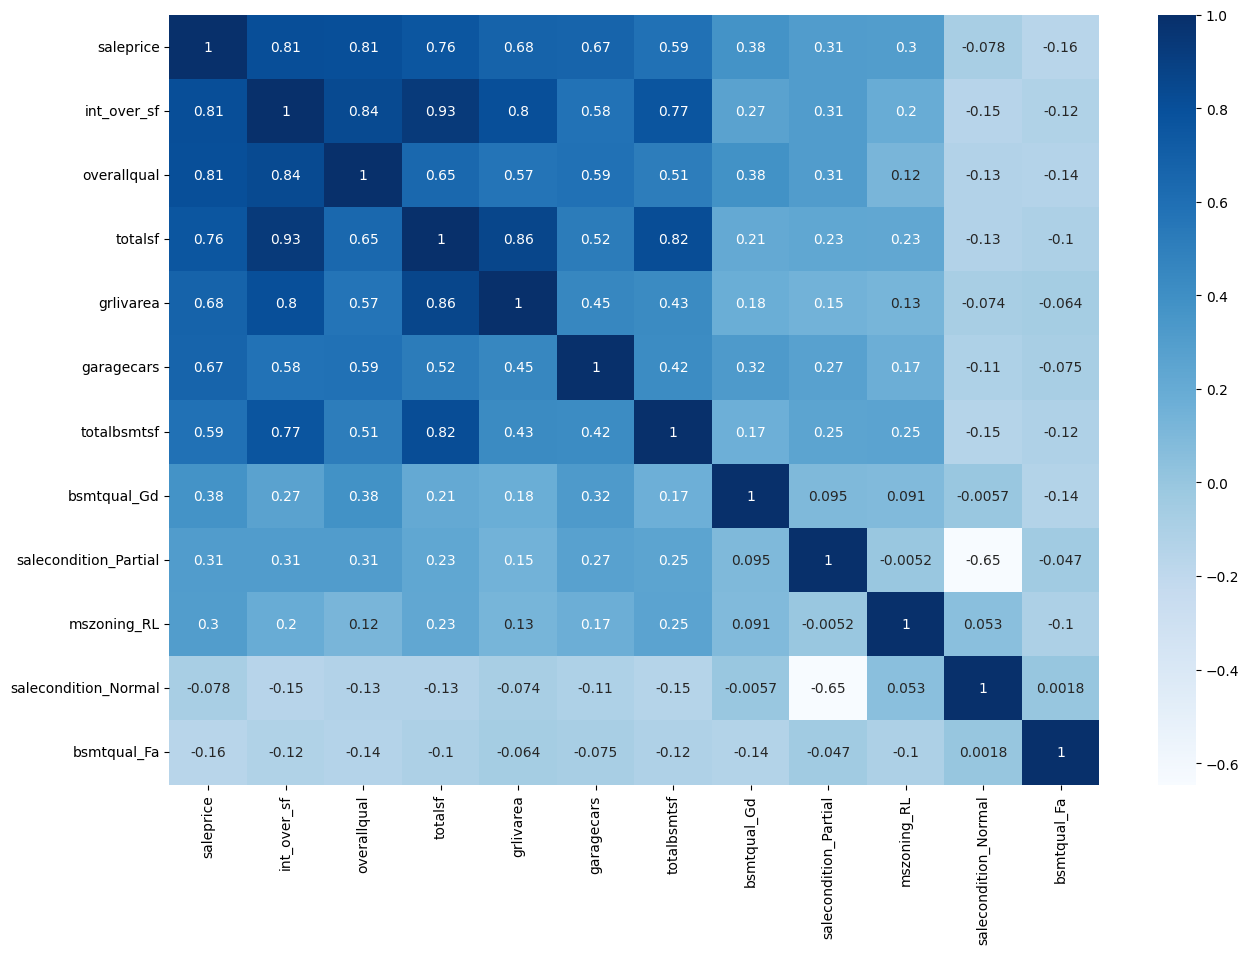

In [15]:
corr_df = house_price_reduced_df.copy()
corr_df['saleprice'] = np.log1p(house_price_df['saleprice'])
heatmap_features_and_target(corr_df, 12)

### 3. Now, split your data into train and test sets where 20% of the data resides in the test set.

In [16]:
# X is the feature set
X = house_price_reduced_df
# Y is the target variable
Y = np.log1p(house_price_df['saleprice'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


Let's also create a scaled version of our dataset.

In [17]:
# Scale the features so we can more easily determine which are the most significant
scaler = StandardScaler()
house_price_reduced_and_saleprice_df = house_price_reduced_df.copy()
house_price_reduced_and_saleprice_df['saleprice'] = np.log1p(house_price_df['saleprice'])
scaled_house_price_saleprice_arr = scaler.fit_transform(house_price_reduced_and_saleprice_df)
scaled_house_price_saleprice_df = pd.DataFrame(scaled_house_price_saleprice_arr,columns=house_price_reduced_and_saleprice_df.columns)

X_scaled = scaled_house_price_saleprice_df.drop(columns=['saleprice'])
Y_scaled = scaled_house_price_saleprice_df['saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


And a scaled version of the original house price dataset.

In [18]:
# Scale all the columns of our original dataset and find out which features are important
def scale_data(df):
  # Subset variables from our dataset.
  for categorical in df.describe(exclude=np.number).columns:
      df = pd.concat([df, pd.get_dummies(df[categorical],drop_first=True,prefix=categorical)], axis=1)

  # Then, add the continuous variables from our dataset.
  all_df = df[df.describe(include=np.number).columns]

  # And concatenate dummy versions of the categorical variables.
  for column in df.describe(exclude=np.number).columns:
      all_df = pd.concat([all_df,pd.get_dummies(df[column],drop_first=True,prefix=column)],axis=1)

  # Transform the target variable
  all_df['log_saleprice'] = np.log(all_df['saleprice'])
  all_df = all_df.drop(columns=['saleprice'])

  # Scale the features so we can more easily determine which are the most significant
  scaler = StandardScaler()
  scaled_all_arr = scaler.fit_transform(all_df)
  scaled_all_df = pd.DataFrame(scaled_all_arr,columns=all_df.columns)
  return scaled_all_df

scaled_all_house_price_df = scale_data(house_price_df)
X_all_scaled = scaled_all_house_price_df.drop(columns=['log_saleprice'])
Y_all_scaled = scaled_all_house_price_df['log_saleprice']

X_all_scl_train, X_all_scl_test, y_all_scl_train, y_all_scl_test = train_test_split(X_all_scaled, Y_all_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))


The number of observations in training set is 1156
The number of observations in test set is 289


### 4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one.

In [19]:
# Capture k-fold output in a dataframe for comparisons
kfold_df = pd.DataFrame(columns=['Model','Fold_1','Fold_2','Fold_3','Fold_4','Fold_5'])

We also define two helper functions.

In [20]:
# Returns a dictonary of statistics to compare various model performance
# provided that five folds are defined.
def kfold_xval(model,train_data,target_data,**kwargs):
    num_folds = kwargs.get('num_folds',10)
    ret_5 = kwargs.get('ret_5',num_folds==5)
    print("Cross-validation using {} folds".format(num_folds))
    cross_val_array = cross_val_score(model, train_data, target_data, cv=num_folds)
    if ret_5:
        ret_dict = {'Model': str(model),
                    'Fold_1': cross_val_array[0],
                    'Fold_2': cross_val_array[1],
                    'Fold_3': cross_val_array[2],
                    'Fold_4': cross_val_array[3],
                    'Fold_5': cross_val_array[4],
                   }
        print(ret_dict)
        return(ret_dict)
    else:
        print(cross_val_array)

In [21]:
def comp_train_test(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)

    # We are making predictions here
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    # Low alpha helps us understand whether there is a concentration of observations
    # at a particular point, or if it is an outlier
    tips = sns.load_dataset("tips")
    ax = sns.regplot(data=tips,x=y_test,y=y_preds_test,scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "red"})
    ax.set(xlabel='Test value', ylabel='Predicted value',title='Test values vs. predicted values,\n{}'.format(str(model)))
    plt.show()

    print("R-squared of the model on the training set is: {}".format(model.score(X_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model on the test set is: {}".format(model.score(X_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

### Linear Regression

In [22]:
linear = LinearRegression()
cv_results = kfold_xval(linear,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression()', 'Fold_1': 0.8334634168478622, 'Fold_2': 0.8050955684609286, 'Fold_3': 0.8395548798722714, 'Fold_4': 0.7187132448403961, 'Fold_5': 0.8794206323090439}


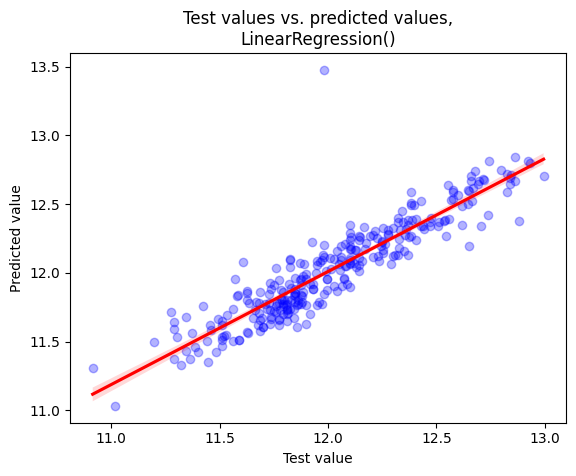

R-squared of the model on the training set is: 0.8303562153410899
-----Test set statistics-----
R-squared of the model on the test set is: 0.8232639369278809
Mean absolute error of the prediction is: 0.11358756947836395
Mean squared error of the prediction is: 0.02778674332170331
Root mean squared error of the prediction is: 0.16669356112850703
Mean absolute percentage error of the prediction is: 0.9467869510551002


In [23]:
comp_train_test(linear,X_train,y_train,X_test,y_test)

Next, let's try both of the scaled datasets.

In [24]:
linear_scl = LinearRegression()
cv_results = kfold_xval(linear_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression()', 'Fold_1': 0.8334634168478635, 'Fold_2': 0.8050955684609293, 'Fold_3': 0.8395548798722718, 'Fold_4': 0.7187132448403956, 'Fold_5': 0.8794206323090445}


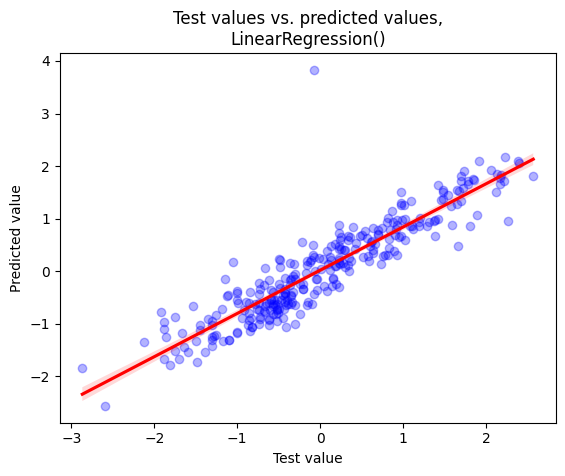

R-squared of the model on the training set is: 0.8303562153410898
-----Test set statistics-----
R-squared of the model on the test set is: 0.8232639369278717
Mean absolute error of the prediction is: 0.2970702308457146
Mean squared error of the prediction is: 0.190061566014579
Root mean squared error of the prediction is: 0.43596050969620975
Mean absolute percentage error of the prediction is: 97.18180960559613


In [25]:
comp_train_test(linear_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

In [26]:
linear_all_scl = LinearRegression()
cv_results = kfold_xval(linear_all_scl,X_all_scl_train,y_all_scl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'LinearRegression()', 'Fold_1': -1.3157473941145508e+25, 'Fold_2': -6.372574511005485e+24, 'Fold_3': -4.629213819121195e+23, 'Fold_4': -6.15551625339757e+23, 'Fold_5': -9.380676359234983e+21}


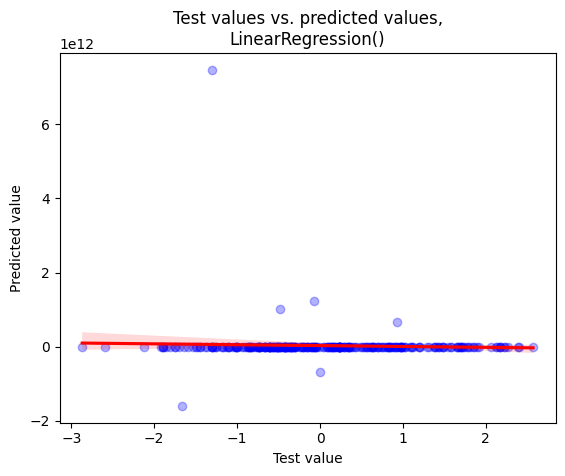

R-squared of the model on the training set is: 0.9391184681434774
-----Test set statistics-----
R-squared of the model on the test set is: -1.9895734959097352e+23
Mean absolute error of the prediction is: 43904292283.54954
Mean squared error of the prediction is: 2.1395802342170108e+23
Root mean squared error of the prediction is: 462555967880.3216
Mean absolute percentage error of the prediction is: 55849403137142.875


In [27]:
comp_train_test(linear_all_scl,X_all_scl_train,y_all_scl_train,X_all_scl_test,y_all_scl_test)

### Ridge Regression

We set the constant which multiplies the L2 term to `alpha=0.1`.

In [28]:
ridge = Ridge(alpha=0.1)
cv_results = kfold_xval(ridge,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Ridge(alpha=0.1)', 'Fold_1': 0.8334035785850129, 'Fold_2': 0.805125269266362, 'Fold_3': 0.8396170813543548, 'Fold_4': 0.718663575649342, 'Fold_5': 0.8794297816567485}


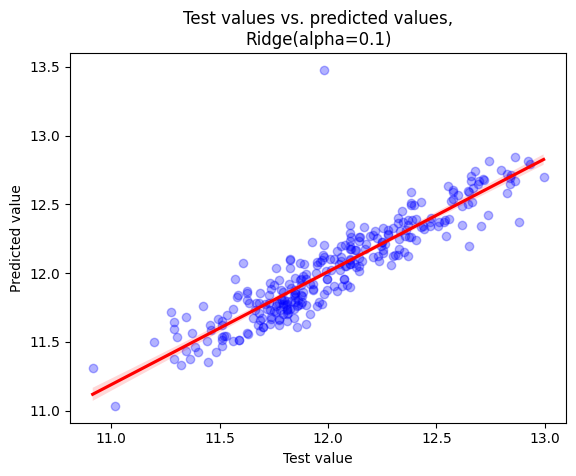

R-squared of the model on the training set is: 0.8303557935588137
-----Test set statistics-----
R-squared of the model on the test set is: 0.8231058056394949
Mean absolute error of the prediction is: 0.11361166527713432
Mean squared error of the prediction is: 0.027811604990822424
Root mean squared error of the prediction is: 0.16676811742902906
Mean absolute percentage error of the prediction is: 0.9469902988514304


In [29]:
comp_train_test(ridge,X_train,y_train,X_test,y_test)

We will once again try the two scaled datasets.

In [30]:
ridge_scl = Ridge(alpha=0.1)
cv_results = kfold_xval(ridge_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Ridge(alpha=0.1)', 'Fold_1': 0.8334249462086072, 'Fold_2': 0.8051742178613787, 'Fold_3': 0.839656527663395, 'Fold_4': 0.7183135691169238, 'Fold_5': 0.8796466463117862}


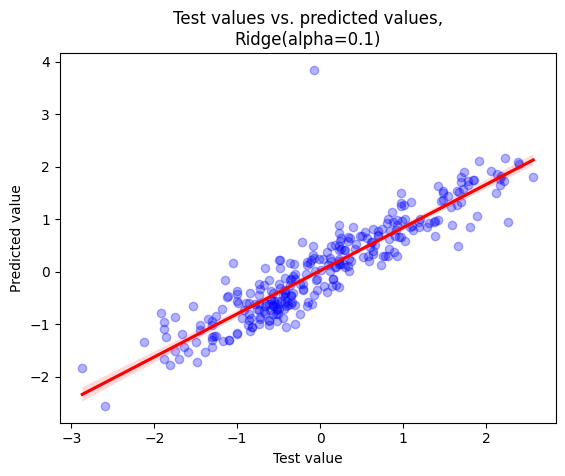

R-squared of the model on the training set is: 0.830353493261334
-----Test set statistics-----
R-squared of the model on the test set is: 0.8228685809386084
Mean absolute error of the prediction is: 0.29710632844338697
Mean squared error of the prediction is: 0.19048673095910967
Root mean squared error of the prediction is: 0.43644785594514
Mean absolute percentage error of the prediction is: 97.20663936722606


In [31]:
comp_train_test(ridge_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

In [32]:
ridge_all_scl = Ridge(alpha=0.1)
cv_results = kfold_xval(ridge_all_scl,X_all_scl_train,y_all_scl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Ridge(alpha=0.1)', 'Fold_1': 0.8988032613161279, 'Fold_2': 0.8023832569333447, 'Fold_3': 0.8744515426333458, 'Fold_4': 0.7542934163547926, 'Fold_5': 0.8842788027538462}


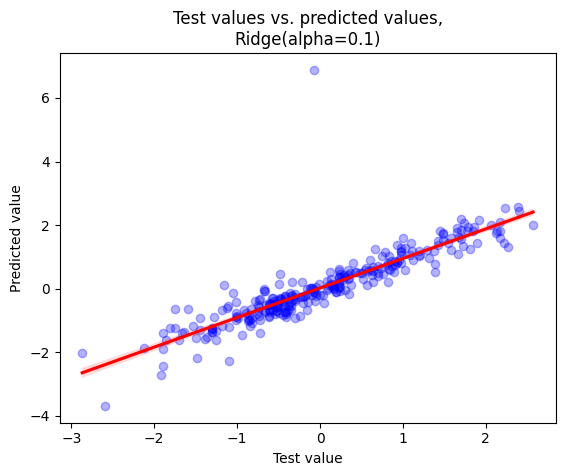

R-squared of the model on the training set is: 0.9392116476334174
-----Test set statistics-----
R-squared of the model on the test set is: 0.7409105987832799
Mean absolute error of the prediction is: 0.2663873834568456
Mean squared error of the prediction is: 0.27862381705328315
Root mean squared error of the prediction is: 0.52784828980805
Mean absolute percentage error of the prediction is: 103.62690456213717


In [33]:
comp_train_test(ridge_all_scl,X_all_scl_train,y_all_scl_train,X_all_scl_test,y_all_scl_test)

### Lasso Regression

We set the constant which multiplies the L1 term to `alpha=0.1`.

In [34]:
lasso = Lasso(alpha=0.1)
cv_results = kfold_xval(lasso,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Lasso(alpha=0.1)', 'Fold_1': 0.7588692351987032, 'Fold_2': 0.7218700291603872, 'Fold_3': 0.7543687106200391, 'Fold_4': 0.4781924318393147, 'Fold_5': 0.7997673166245971}


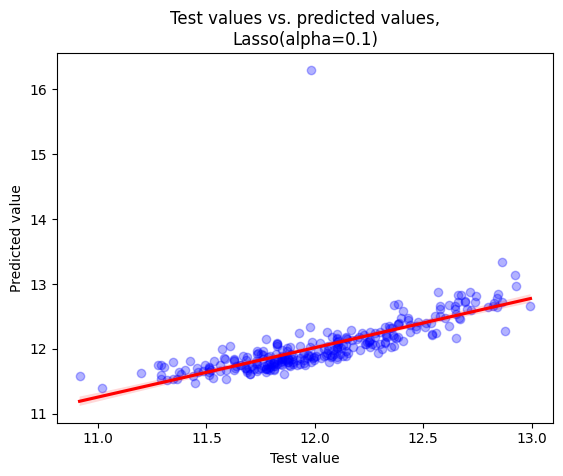

R-squared of the model on the training set is: 0.7202087576674092
-----Test set statistics-----
R-squared of the model on the test set is: 0.385975007987861
Mean absolute error of the prediction is: 0.1532513246457502
Mean squared error of the prediction is: 0.09653804973119715
Root mean squared error of the prediction is: 0.31070572851364864
Mean absolute percentage error of the prediction is: 1.2803091652006322


In [35]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

Again, we try the two scaled datasets.

In [36]:
lasso_scl = Lasso(alpha=0.1)
cv_results = kfold_xval(lasso_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Lasso(alpha=0.1)', 'Fold_1': 0.7779264889490269, 'Fold_2': 0.770510410254776, 'Fold_3': 0.8033252232506062, 'Fold_4': 0.6982887559300568, 'Fold_5': 0.8396214269443956}


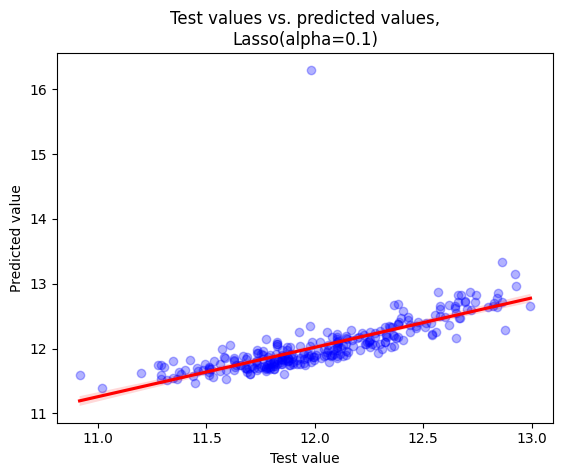

R-squared of the model on the training set is: 0.7202087576674092
-----Test set statistics-----
R-squared of the model on the test set is: 0.385975007987861
Mean absolute error of the prediction is: 0.1532513246457502
Mean squared error of the prediction is: 0.09653804973119715
Root mean squared error of the prediction is: 0.31070572851364864
Mean absolute percentage error of the prediction is: 1.2803091652006322


In [37]:
comp_train_test(lasso,X_train,y_train,X_test,y_test)

In [38]:
lasso_all_scl = Lasso(alpha=0.1)
cv_results = kfold_xval(lasso_all_scl,X_all_scl_train,y_all_scl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'Lasso(alpha=0.1)', 'Fold_1': 0.8101816914942912, 'Fold_2': 0.8114178297150486, 'Fold_3': 0.8336191924651507, 'Fold_4': 0.760468573579191, 'Fold_5': 0.8658797868894621}


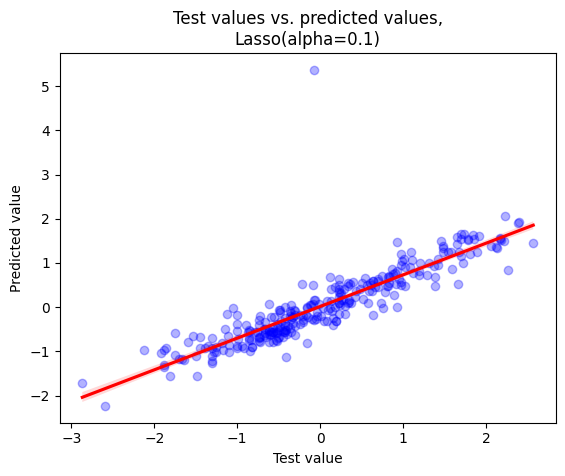

R-squared of the model on the training set is: 0.8259912015876176
-----Test set statistics-----
R-squared of the model on the test set is: 0.7573961814382872
Mean absolute error of the prediction is: 0.3157308432315304
Mean squared error of the prediction is: 0.2608952803238188
Root mean squared error of the prediction is: 0.5107790915100371
Mean absolute percentage error of the prediction is: 102.623928393768


In [39]:
comp_train_test(lasso_all_scl,X_all_scl_train,y_all_scl_train,X_all_scl_test,y_all_scl_test)

### Elastic Net Regression.

We favor the Ridge penalty and set `alpha=0.1`.

In [40]:
elastic = ElasticNet(l1_ratio=.01, alpha=0.1)
cv_results = kfold_xval(elastic,X_train,y_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'ElasticNet(alpha=0.1, l1_ratio=0.01)', 'Fold_1': 0.8187712423854752, 'Fold_2': 0.7901623218291376, 'Fold_3': 0.8311532650624207, 'Fold_4': 0.6672264595805647, 'Fold_5': 0.8695858212636495}


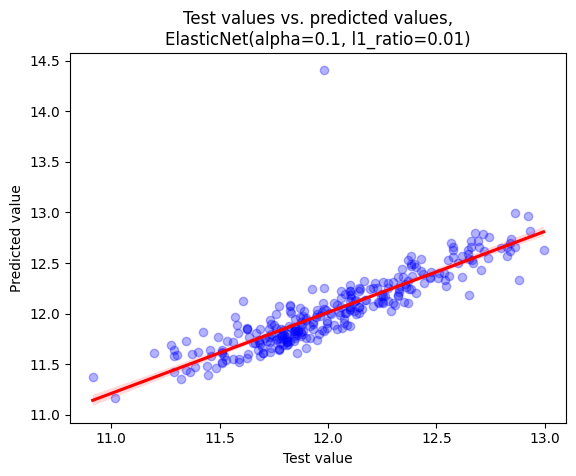

R-squared of the model on the training set is: 0.8114857312479595
-----Test set statistics-----
R-squared of the model on the test set is: 0.7301945828254062
Mean absolute error of the prediction is: 0.12168871152872646
Mean squared error of the prediction is: 0.042419264883003974
Root mean squared error of the prediction is: 0.20595937677853848
Mean absolute percentage error of the prediction is: 1.01489859612564


In [41]:
comp_train_test(elastic,X_train,y_train,X_test,y_test)

We now see favorable results with the scaled versions of the datasets.

In [42]:
elastic_scl = ElasticNet(l1_ratio=.01, alpha=0.1)
cv_results = kfold_xval(elastic_scl,Xscl_train,yscl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'ElasticNet(alpha=0.1, l1_ratio=0.01)', 'Fold_1': 0.8326214670473742, 'Fold_2': 0.8003711840515553, 'Fold_3': 0.840808566567324, 'Fold_4': 0.6882656179597917, 'Fold_5': 0.8690335731698897}


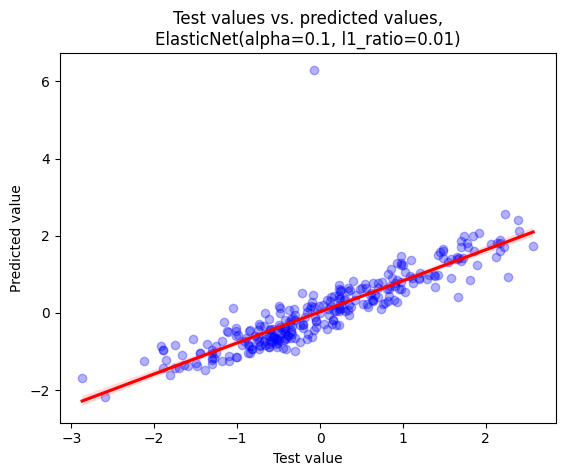

R-squared of the model on the training set is: 0.8190754363558916
-----Test set statistics-----
R-squared of the model on the test set is: 0.7413486232475297
Mean absolute error of the prediction is: 0.3099720123374132
Mean squared error of the prediction is: 0.27815311070575716
Root mean squared error of the prediction is: 0.5274022285748868
Mean absolute percentage error of the prediction is: 104.29808739885713


In [43]:
comp_train_test(elastic_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

In [44]:
elastic_all_scl = ElasticNet(l1_ratio=.01, alpha=0.1)
cv_results = kfold_xval(elastic_all_scl,X_all_scl_train,y_all_scl_train,num_folds=5)
kfold_df = kfold_df.append(cv_results,ignore_index=True)

Cross-validation using 5 folds
{'Model': 'ElasticNet(alpha=0.1, l1_ratio=0.01)', 'Fold_1': 0.8966913350736474, 'Fold_2': 0.8406224598462095, 'Fold_3': 0.8862841554360623, 'Fold_4': 0.7844870749857394, 'Fold_5': 0.9027446190336622}


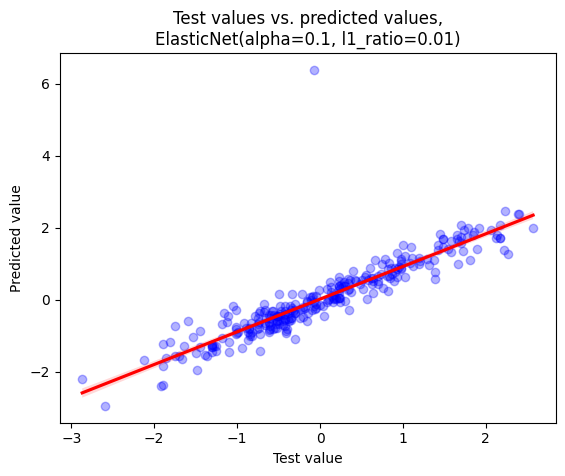

R-squared of the model on the training set is: 0.932288018949911
-----Test set statistics-----
R-squared of the model on the test set is: 0.7830200401172229
Mean absolute error of the prediction is: 0.2426585088918383
Mean squared error of the prediction is: 0.23333947418419576
Root mean squared error of the prediction is: 0.4830522478823546
Mean absolute percentage error of the prediction is: 98.95908540763728


In [45]:
comp_train_test(elastic_all_scl,X_all_scl_train,y_all_scl_train,X_all_scl_test,y_all_scl_test)

### 5. Evaluate your best model on the test set.

We will compare our scores from cross validation.

In [46]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
kfold_df['avg_score'] = kfold_df.mean(axis=1)
kfold_df.sort_values(['avg_score'],ascending=False)
kfold_df.drop(index=2)

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg_score
0,LinearRegression(),0.833,0.805,0.840,0.719,0.879,0.815
1,LinearRegression(),0.833,0.805,0.840,0.719,0.879,0.815
3,Ridge(alpha=0.1),0.833,0.805,0.840,0.719,0.879,0.815
4,Ridge(alpha=0.1),0.833,0.805,0.840,0.718,0.880,0.815
5,Ridge(alpha=0.1),0.899,0.802,0.874,0.754,0.884,0.843
6,Lasso(alpha=0.1),0.759,0.722,0.754,0.478,0.800,0.703
7,Lasso(alpha=0.1),0.778,0.771,0.803,0.698,0.840,0.778
8,Lasso(alpha=0.1),0.810,0.811,0.834,0.760,0.866,0.816
9,"ElasticNet(alpha=0.1, l1_ratio=0.01)",0.819,0.790,0.831,0.667,0.870,0.795
10,"ElasticNet(alpha=0.1, l1_ratio=0.01)",0.833,0.800,0.841,0.688,0.869,0.806


These results show that `ElasticNet(l1_ratio=0.01)` had the best performance.

### 6. So far, we have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

We will now add two aditional features through uploading two CSV files.

The first feature is the quarterly real GDP per capita from the [Federal Reserve Bank of St. Louis' website](https://fred.stlouisfed.org/series/A939RX0Q048SBEA), covering the months/years of 2006 through 2010.

The second feature is the monthly federal interest rate data from [the same site](https://fred.stlouisfed.org/series/FEDFUNDS), also covering the months of 2006 through 2010. Lower interest rates encourage people to buy homes.

In [47]:
from google.colab import files
uploaded = files.upload()

Saving real_gdp_per_capita_2006_2010.csv to real_gdp_per_capita_2006_2010 (5).csv
Saving fed_interest_rate_2006_2010.csv to fed_interest_rate_2006_2010 (4).csv


We will need the following two helper functions.

In [48]:
def lookup_gdp(month,year):
    if month in [1,2,3]:
        retmo = 1
    elif month in [4,5,6]:
        retmo = 4
    elif month in [7,8,9]:
        retmo = 7
    else:
        retmo=10
    datestr = "{}-{:02d}-01".format(year,retmo)
    return(int(gdp_df.loc[gdp_df['DATE'] == datestr]['GDP'].values[0]))

In [49]:
def lookup_int_rate(month,year):
    datestr = "{}-{:02d}-01".format(year,month)
    return(int_rate_df.loc[int_rate_df['DATE'] == datestr]['FEDFUNDS'].values[0])

### GDP per capita, by quarter

In [50]:
gdp_df = pd.read_csv('real_gdp_per_capita_2006_2010.csv')
gdp_df.rename(columns={"A939RX0Q048SBEA": "GDP"},inplace=True)
house_price_reduced_df['gdp'] = house_price_df.apply(lambda row: lookup_gdp(row['mosold'],row['yrsold']), axis=1)
house_price_reduced_df['gdp'].describe()

count   1445.000 
mean    54628.709
std     974.442  
min     53017.000
25%     53683.000
50%     54945.000
75%     55474.000
max     55857.000
Name: gdp, dtype: float64

###  Federal interest rate, by month

In [51]:
int_rate_df = pd.read_csv('fed_interest_rate_2006_2010.csv')
house_price_reduced_df['interest_rate'] = house_price_df.apply(lambda row: lookup_int_rate(row['mosold'],row['yrsold']), axis=1)
house_price_reduced_df['interest_rate'].describe()

count   1445.000
mean    2.685   
std     2.229   
min     0.110   
25%     0.180   
50%     2.010   
75%     5.240   
max     5.260   
Name: interest_rate, dtype: float64

### Retraining the model

In [52]:
# Rerun the scaler now that we've added new features
house_price_reduced_df['saleprice'] = np.log(house_price_df['saleprice'])
scaled_house_price_reduced_arr = scaler.fit_transform(house_price_reduced_df)
scaled_house_price_reduced_df = pd.DataFrame(scaled_house_price_reduced_arr,columns=house_price_reduced_df.columns)
X_scaled = scaled_house_price_reduced_df.drop(columns=['saleprice'])
Y_scaled = scaled_house_price_reduced_df['saleprice']

Xscl_train, Xscl_test, yscl_train, yscl_test = train_test_split(X_scaled, Y_scaled,
                                                                test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(Xscl_train.shape[0]))
print("The number of observations in test set is {}".format(Xscl_test.shape[0]))

The number of observations in training set is 1156
The number of observations in test set is 289


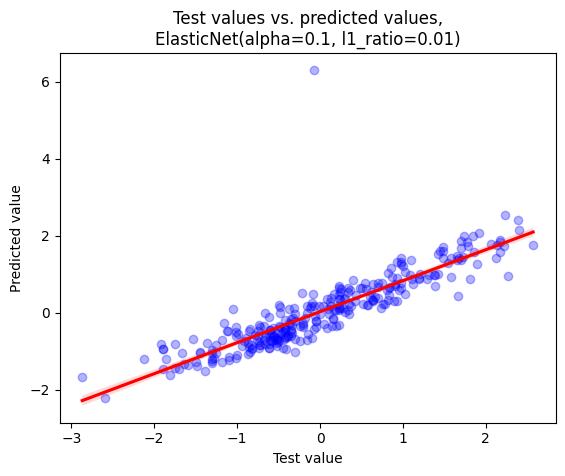

R-squared of the model on the training set is: 0.8197325528896414
-----Test set statistics-----
R-squared of the model on the test set is: 0.7402900377535689
Mean absolute error of the prediction is: 0.3101367524988682
Mean squared error of the prediction is: 0.27929116616907335
Root mean squared error of the prediction is: 0.5284800527636528
Mean absolute percentage error of the prediction is: 105.11332907997426


In [53]:
comp_train_test(elastic_scl,Xscl_train,yscl_train,Xscl_test,yscl_test)

These stats are not significantly better than the scaled version of the original house price dataset.

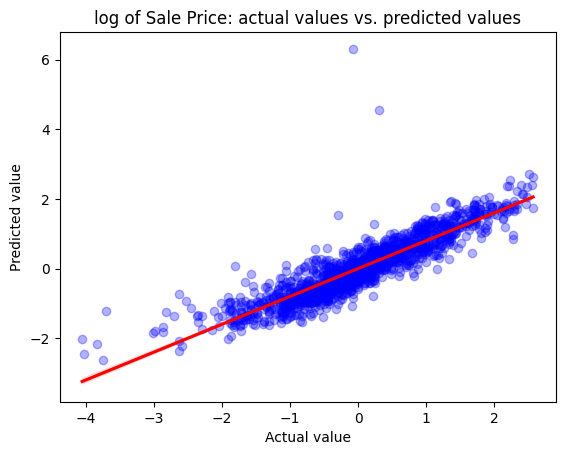

In [54]:
y_scaled_predicted = elastic_scl.predict(X_scaled)
tips = sns.load_dataset("tips")
ax = sns.regplot(data=tips,x=Y_scaled,y=y_scaled_predicted,scatter_kws={"color": "blue", 'alpha':0.3}, line_kws={"color": "red"})
ax.set(xlabel='Actual value', ylabel='Predicted value',
       title='log of Sale Price: actual values vs. predicted values')
plt.show()

In [55]:
print("R-squared of the model on the full dataset is: {}".format(elastic_scl.score(X_scaled, Y_scaled)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_scaled, y_scaled_predicted)))
print("Mean squared error of the prediction is: {}".format(mse(Y_scaled, y_scaled_predicted)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_scaled, y_scaled_predicted)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_scaled - y_scaled_predicted) / Y_scaled)) * 100))

R-squared of the model on the full dataset is: 0.8027193335054923
Mean absolute error of the prediction is: 0.2997604816860489
Mean squared error of the prediction is: 0.19728066649450776
Root mean squared error of the prediction is: 0.44416288284199046
Mean absolute percentage error of the prediction is: 166.68961142756987


Further analysis can be found inside [this Github repository](https://github.com/jesservillines/Housing-Prices).